<!--NAVIGATION-->
< [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) | [Contents](Index.ipynb) | [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb) >

# 6.5. 决策树与随机森林

本节将介绍另一种强大的算法——无参数算法**随机森林**。随机森林是一种**集成**方法，通过集成多个比较简单的评估器形成累积效果。这种集成方法的学习效果经常出人意料，往往能超过各个组成部分的总和；也就是说，若干评估器的多数投票（majority vote）的最终效果往往优于单个评估器投票的效果！

后面将通过示例来演示，首先还是导入标准的程序库：

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## 1. 随机森林的诱因： 决策树

随机森林是建立在决策树基础上的**集成学习器**。因此，首先来介绍一下决策树。

决策树采用非常直观的方式对事物进行分类或打标签：你只需问一系列问题就可以进行分类了。例如，如果你想建一棵决策树来判断旅行时遇到的一只动物的种类，你就可以提出如下图所示的问题。

![](figures/05.08-decision-tree.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Example)

二叉树分支方法可以非常有效地进行分类：在一棵结构合理的决策树中，每个问题基本上都可将种类可能性减半；即使是对大量种类进行决策时，也可以很快地缩小选择范围。不过，决策树的难点在于如何设计每一步的问题。在实现决策树的机器学习算法中，问题通常因分类边界是与特征轴平行的形式分割数据而造成的（其实也有多变量决策树可以获得多特征线性组合的决策边界）；也就是说，**决策树的每个节点都根据一个特征的阈值将数据分成两组**。下面通过示例来演示。

### （1）. 创建一棵决策树

看看下面的二维数据，它一共有四种标签:

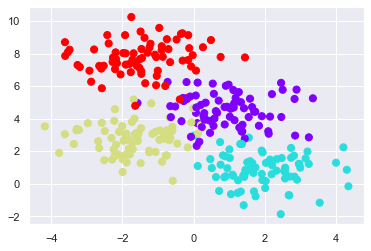

In [39]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

在这组数据上构建的简单决策树不断将数据的一个特征或另一个特征按照某种判定条件进行分割。每分割一次，都将新区域内点的多数投票结果标签分配到该区域上。下图展示了决策树对这组数据前四次分割的可视化结果。

![](figures/05.08-decision-tree-levels.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Levels)
两维特征，形成了一个个方格区域，内里对应不同的分类

需要注意的是，在第一次分割之后，上半个分支里的所有数据点都没有变化，因此这个分支不需要继续分割。除非一个节点只包含一种颜色，那么每次分割都需要按照两种特征中的一种对每个区域进行分割。

如果想在Scikit-Learn中使用决策树拟合数据，可以用`DecisionTreeClassifier`评估器：

In [40]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

让我们快速写一个辅助函数，对分类器的结果进行可视化：

In [41]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # 画出训练数据
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 用评估器拟合数据
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # 为结果生成彩色图
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

现在就可以检查决策树分类的结果了：

c:\users\feynman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


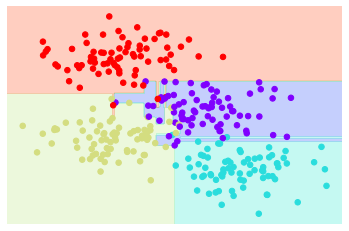

In [42]:
visualize_classifier(DecisionTreeClassifier(), X, y)

如果你正在运行Notebook，那么可以用(https://github.com/jakevdp/PythonDataScienceHandbook)里的辅助脚本(helpers_05_08.py)来生成决策树创建过程的交互式可视化（如下图所示）：

In [43]:
# helpers_05_08.py文件位于在线附录
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

SyntaxError: invalid syntax (helpers_05_08.py, line 7)

请注意，随着决策树深度的不断增加，我们可能会看到形状非常奇怪的分类区域。例如，在深度为5的时候，在绿色与蓝色区域中间有一个狭长的浅紫色区域。这显然不是根据数据本身的分布情况生成的正确分类结果，而更像是一个特殊的数据样本或数据噪音形成的干扰结果。也就是说，这棵决策树刚刚分到第5层，数据就出现了过拟合。

### （2）. 决策树与过拟合

这种过拟合其实正是决策树的一般属性——决策树非常容易陷得很深，因此往往会拟合局部数据，而没有对整个数据分布的大局观。换个角度看这种过拟合，可以认为模型训练的是数据的不同子集。例如，在下图中我们训练了两棵不同的决策树，每棵树拟合一半数据。

![](figures/05.08-decision-tree-overfitting.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

显然，在一些区域，两棵树产生了一致的结果（例如4个角上）；而在另一些区域，两棵树的分类结果差异很大（例如两类接壤的区域）。不一致往往都发生在分类比较模糊的地方，因此假如将**两棵树**的结果组合起来，可能就会获得更好的结果！

如果你正在运行Notebook，可以用下面的函数交互地浏览决策树对数据随机子集训练的结果（如下图所示）：

In [ ]:
# helpers_05_08.py文件位于在线附录
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

就像用两棵决策树的信息改善分类结果一样，我们可能想用更多决策树的信息来改善分类结果。

## 2. 评估器集成算法：随机森林

通过组合多个过拟合评估器来降低过拟合程度的想法其实是一种集成学习方法，称为**装袋算法**。装袋算法使用并行评估器对数据进行有放回抽取集成（也可以说是大杂烩），每个评估器都对数据过拟合，通过求均值可以获得更好的分类结果。随机决策树的集成算法就是**随机森林**。

我们可以用Scikit-Learn的`BaggingClassifier`元评估器来实现这种装袋分类器（如下图所示）：

c:\users\feynman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


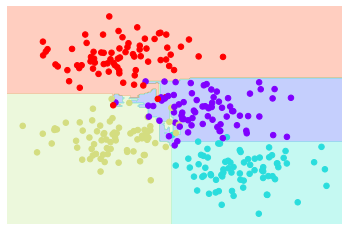

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

在这个示例中，我们让每个评估器拟合样本80%的随机数。其实，如果我们用随机方法（stochasticity）确定数据的分割方式，决策树拟合的随机性会更有效；这样做可以让所有数据在每次训练时都被拟合，但拟合的结果却仍然是随机的。例如，当需要确定对哪个特征进行分割时，随机树可能会从最前面的几个特征中挑选。关于随机策略选择的更多技术细节，请参考Scikit-Learn 文档 [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest)。

在Scikit-Learn里对随机决策树集成算法的优化是通过`RandomForestClassifier`评估器实现的，它会自动进行随机化决策。你只要选择一组评估器，它们就可以非常快速地完成（如果需要可以并行计算）每棵树的拟合任务（如下图所示）：

c:\users\feynman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


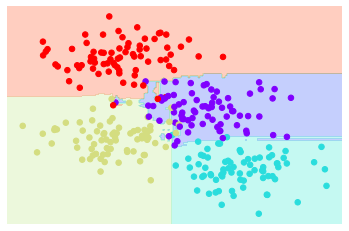

In [45]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

从图中可以看出，如果使用100棵随机决策树，就可以得到一个非常接近我们直觉的“关于数据空间应该如何分割”的整体模型。

## 3. 随机森林回归

前面介绍了随机森林分类的内容。其实随机森林也可以用作回归（处理连续变量，而不是离散变量）。随机森林回归的评估器是 `RandomForestRegressor`，其语法与我们之前看到的非常类似。

下面的数据通过快慢振荡组合而成（如下图所示）：

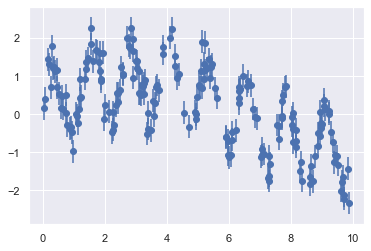

In [46]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

通过随机森林回归器，可以获得下面的最佳拟合曲线：

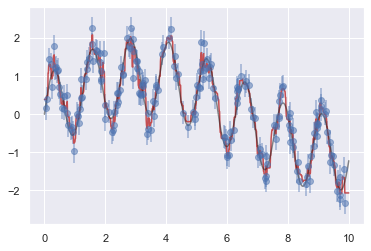

In [47]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)#x[:, None]与x[:,np.newaxis]一样

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

真实模型是平滑曲线，而随机森林模型是锯齿线。从图中可以看出，无参数的随机森林模型非常适合处理多周期数据，不需要我们配置多周期模型！

## 5. 随机森林总结

这一节首先简要介绍了集成评估器的概念，然后重点介绍了随机森林模型——一种随机决策树集成算法。随机森林是一种强大的机器学习方法，它的优势在于以下几点。

- 因为决策树的原理很简单，所以它的训练和预测速度都非常快。另外，多任务可以直接并行计算，因为每棵树都是完全独立的。
- 多棵树可以进行概率分类：多个评估器之间的多数投票可以给出概率的估计值（使用Scikit-Learn的`predict_proba()`方法）。
- 无参数模型很灵活，在其他评估器都欠拟合的任务中表现突出。

随机森林的主要缺点在于其结果不太容易解释，也就是说，如果你想要总结分类模型的意义，随机森林可能不是最佳选择。

<!--NAVIGATION-->
< [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) | [Contents](Index.ipynb) | [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb) >